# Residual U-Net Training

This notebook trains a pseudo-residual U-Net model for enhanced JPEG reconstruction. Inputs to this network is intended to be images decompressed with the 8x8 block DCT network.

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from skimage.util import random_noise, img_as_ubyte

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet, my_unet

Using TensorFlow backend.


# MR Dataset Training

In [2]:
# Train and validation data paths
train_path = "/home/ubuntu/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume1/TIFF/Development/Validation/*.tif"

input_train_path = "/home/ubuntu/volume1/TIFF/Development_unet/Training/*.tif"
input_val_path = "/home/ubuntu/volume1/TIFF/Development_unet/Validation/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

input_train_images = glob.glob(input_train_path)
input_val_images = glob.glob(input_val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

print("Input train set size:", len(input_train_images))
print("Input validation set size:",len(input_val_images))

Train set size: 10740
Validation set size: 5370
Input train set size: 10740
Input validation set size: 5370


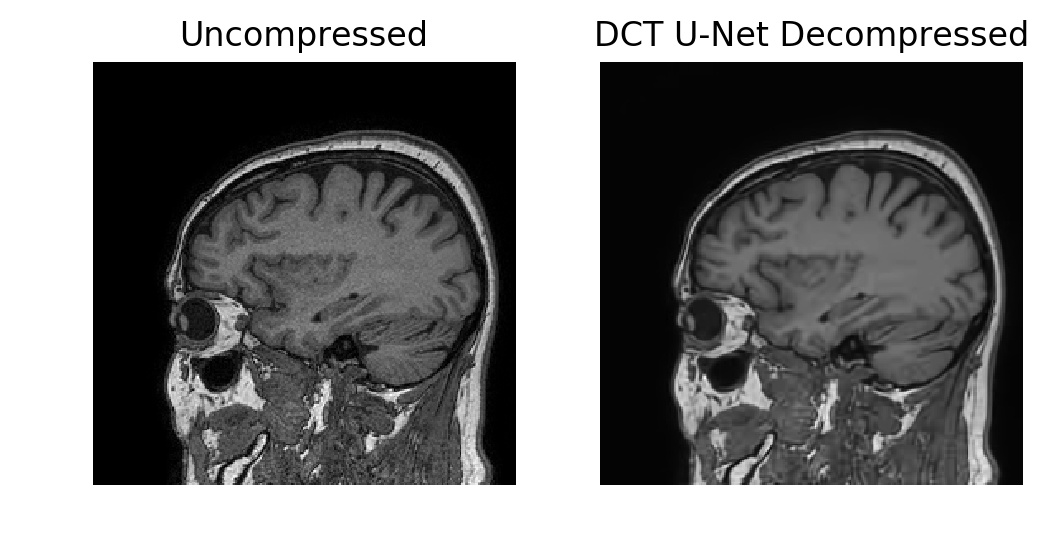

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[300])
im1_array = np.array(im1)

im2 = Image.open(input_train_images[300])
im2_array = np.array(im2)

# buffer2 = io.BytesIO()
# im1_noise.save(buffer2, "JPEG", quality=15)
# im2_noise = Image.open(buffer2)
# im2_noise_array = np.array(im2_noise)

# Display the images
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("DCT U-Net Decompressed")
# plt.subplot(143)
# plt.imshow(im1_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise")
# plt.subplot(144)
# plt.imshow(im2_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise Compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

useNoise = False

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
train_compr = train_unc.copy()


# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1)
    
    im2 = Image.open(input_train_images[ii])
    train_compr[ii,:,:,0] = np.array(im2)

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image
    im2 = Image.open(input_val_images[ii])
    val_compr[ii,:,:,0] = np.array(im2)
    
val_unc /= norm
val_compr /= norm

Validation set


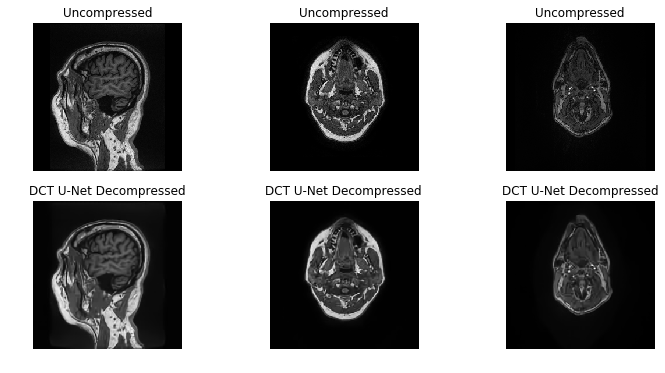

In [5]:
indexes_val = np.arange(len(val_images),dtype = int)
np.random.shuffle(indexes_val)
indexes_val = indexes_val[:3]

print("Validation set")
plt.figure(figsize = (12,6))
for ii in range(3):
    plt.subplot(2,3,ii+1)
    plt.imshow(val_unc[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed")
    plt.subplot(2,3,ii + 4)
    plt.imshow(val_compr[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("DCT U-Net Decompressed")
plt.show()    


In [6]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_pseudo_unet_image_data_augmentation_compress_10_20-pretrained.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


# opt = Adam(lr=0.0001)
# model = unet(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
# model.compile(loss = "mse",optimizer=opt)

opt = Adam(lr=0.0001)
model = my_unet()
model.compile(loss = "mse",optimizer=opt)

# Use pre-train network
model.load_weights("../Models/residual_unet_data_augmentation_imagenet_compress_16_20.hdf5")

In [7]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(train_compr,batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = gen2.next()
        
        yield(batch_comp/255.0, batch_unc/255.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2,compr_range)

(8, 256, 256, 1)
0.0 0.9899105
0.0 0.8490093


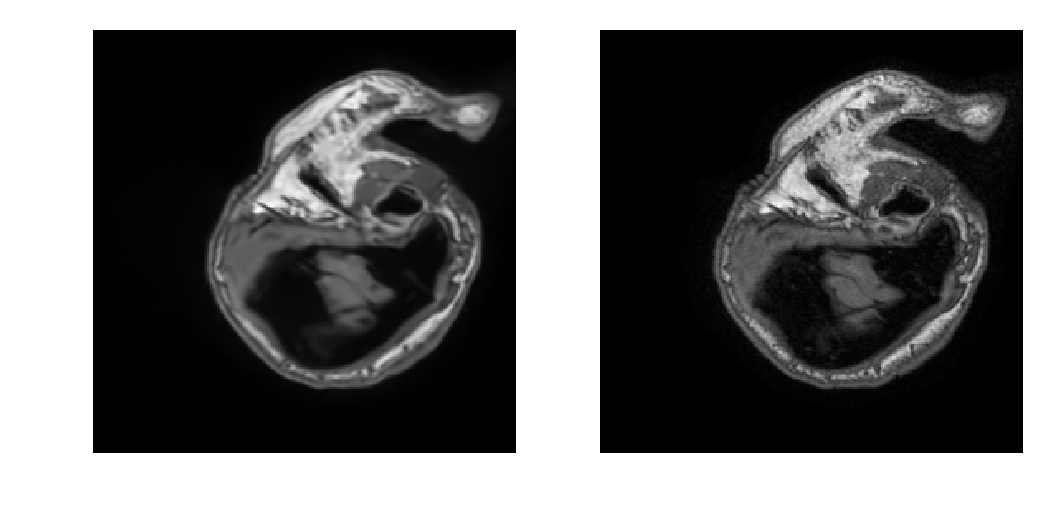

In [8]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure(dpi=200)
    plt.subplot(1,2,1)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [9]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
1343/1342 [==============================] - 130s 97ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 2/30
1343/1342 [==============================] - 126s 94ms/step - loss: 9.7929e-04 - val_loss: 0.0010
Epoch 3/30
1343/1342 [==============================] - 126s 94ms/step - loss: 7.7560e-04 - val_loss: 0.0012
Epoch 4/30
1343/1342 [==============================] - 127s 94ms/step - loss: 7.9769e-04 - val_loss: 9.4541e-04
Epoch 5/30
1343/1342 [==============================] - 127s 94ms/step - loss: 7.1967e-04 - val_loss: 8.2698e-04
Epoch 6/30
1343/1342 [==============================] - 126s 94ms/step - loss: 6.7414e-04 - val_loss: 8.4845e-04
Epoch 7/30
1343/1342 [==============================] - 126s 94ms/step - loss: 7.5491e-04 - val_loss: 8.7994e-04
Epoch 8/30
1343/1342 [==============================] - 126s 94ms/step - loss: 6.3900e-04 - val_loss: 8.2564e-04
Epoch 9/30
1343/1342 [==============================] - 126s 94ms/step - loss: 6.4456e-04 - val_loss: 7.9995e-04

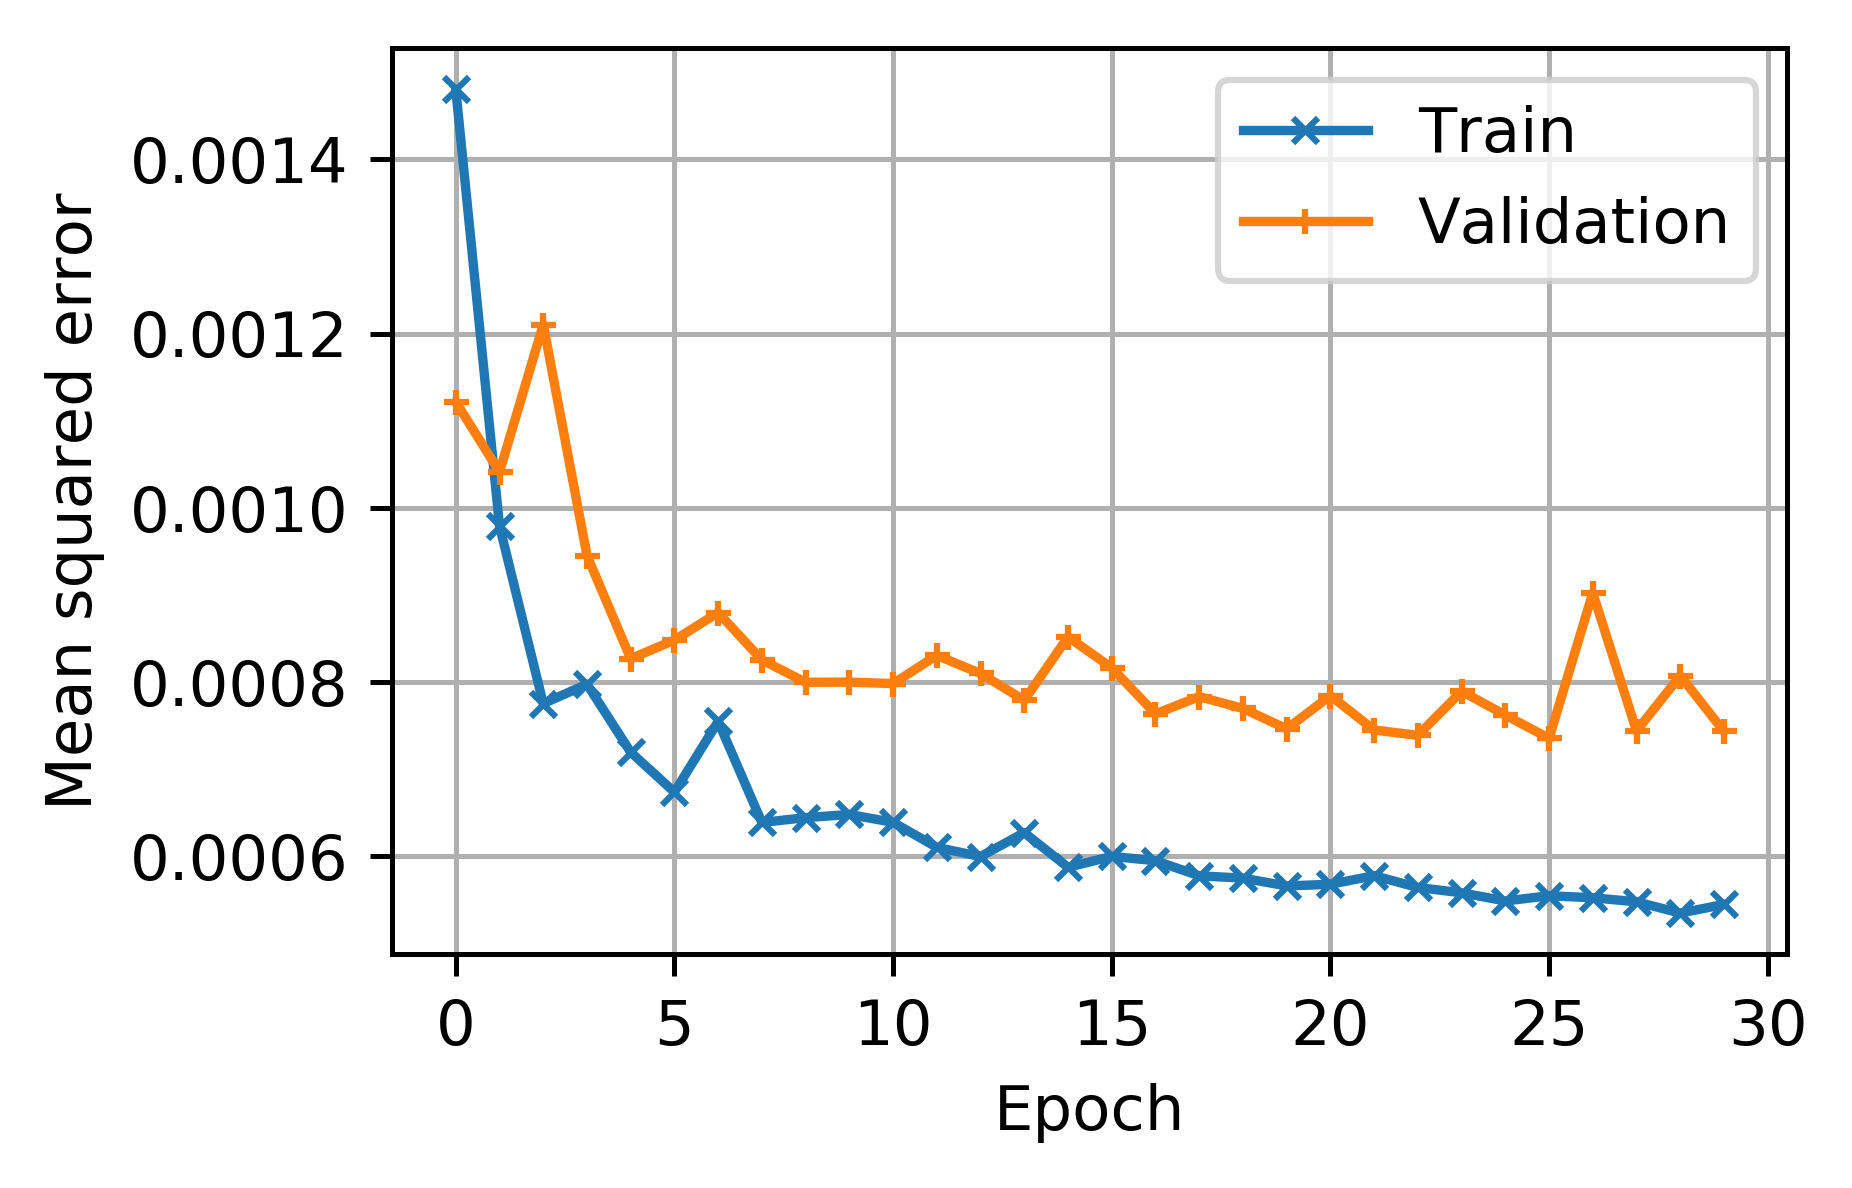

In [10]:
#Saving training history
np.save("../Data/loss_residual_pseudo_unet_image_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_pseudo_unet_image_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()